<a href="https://colab.research.google.com/github/CHRISTIANDAGATTI/A.Supervisado---Grupo9/blob/main/Entregable_Supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DiploDatos Kaggle Competition**

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

# **Librerías**

In [244]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import missingno as msno
import math
import scipy as sp
import numpy as np
from scipy.stats import uniform
from sklearn import preprocessing, svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import *
%config InlineBackend.figure_format = 'svg'
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
#from imblearn.under_sampling import RandomUnderSampler
import pandas_profiling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

In [245]:
#Importamos archivo
train = pd.read_csv('https://raw.githubusercontent.com/CHRISTIANDAGATTI/A.Supervisado---Grupo9/main/train.csv')


In [246]:
#Vista del archivo train
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1


# **Análisis exploratorio**

Análisis exploratorio que nos permita tomar decisiones sobre las variabes a usar, transformaciones de variables, tratamiento de los datos faltantes, etc.

**Dataset:**

train.csv - Registros personales de dos tercios (~8700) de los pasajeros, que se utilizarán como datos de entrenamiento.


**Features:**


PassengerId: Un identificador para cada pasajero.

HomePlanet: El planeta del cual partió el pasajero. Típicamente su planeta de residencia permanente.

CryoSleep: Indica si el pasajero fue elegido a ser puesto en suspensión animada durante la duración del viaje. Los pasajeros en CryoSleep están confinados a sus cabinas.

Cabin: El número de cabina en donde el pasajero se está quedando. Toma la forma piso/número/lado, donde el lado puede ser P por babor o por estribor.

Destination: El destino en donde va a desembarcar el pasajero.

Age: La edad del pasajero.

VIP: Si el pasajero pagó por servicios VIP durante el viaje.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Cantidad que el pasajero ha gastado en cada una de las comodidades de lujo del Spaceship Titanic.

Name: El nombre y apellido de cada pasajero.

Transported: Si el pasajero fue transportado a otra dimensión o no. Esta es la columna target , la columna a predecir.

In [247]:
#Analisis estadístico de cada variable
print(train.shape)
print(train.describe())

(7823, 14)
       PassengerId          Age   RoomService     FoodCourt  ShoppingMall  \
count  7823.000000  7661.000000   7669.000000   7668.000000   7635.000000   
mean   4345.691039    28.879389    226.078237    455.643062    172.600393   
std    2504.576803    14.461548    679.180148   1621.290107    597.923749   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%    2182.500000    19.000000      0.000000      0.000000      0.000000   
50%    4345.000000    27.000000      0.000000      0.000000      0.000000   
75%    6515.500000    38.000000     44.000000     69.000000     28.000000   
max    8692.000000    79.000000  14327.000000  29813.000000  23492.000000   

                Spa        VRDeck  Transported  
count   7665.000000   7654.000000  7823.000000  
mean     305.023222    295.476744     0.506711  
std     1133.423579   1093.485752     0.499987  
min        0.000000      0.000000     0.000000  
25%        0.000000      0.000000     0.000000  
5

In [248]:
# Contamos la existencia de nulos en cada variable
print(train.isna().sum())

PassengerId       0
HomePlanet      179
CryoSleep       196
Cabin           184
Destination     160
Age             162
VIP             184
RoomService     154
FoodCourt       155
ShoppingMall    188
Spa             158
VRDeck          169
Name            184
Transported       0
dtype: int64


In [249]:
#Conteo de valores únicos por variable
train.nunique()

PassengerId     7823
HomePlanet         3
CryoSleep          2
Cabin           6009
Destination        3
Age               80
VIP                2
RoomService     1195
FoodCourt       1400
ShoppingMall    1045
Spa             1238
VRDeck          1229
Name            7623
Transported        2
dtype: int64

In [250]:
#Tipo de datos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7644 non-null   object 
 2   CryoSleep     7627 non-null   object 
 3   Cabin         7639 non-null   object 
 4   Destination   7663 non-null   object 
 5   Age           7661 non-null   float64
 6   VIP           7639 non-null   object 
 7   RoomService   7669 non-null   float64
 8   FoodCourt     7668 non-null   float64
 9   ShoppingMall  7635 non-null   float64
 10  Spa           7665 non-null   float64
 11  VRDeck        7654 non-null   float64
 12  Name          7639 non-null   object 
 13  Transported   7823 non-null   int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 855.8+ KB


In [251]:
# % de campos duplicados
print(f'Duplicados en archivo train: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')

Duplicados en archivo train: 0, (0.0%)


Text(0.5, 1.0, 'Target distribution')

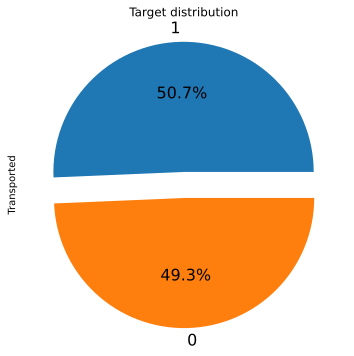

In [252]:
# Gráfico de etiquetas (Transportado: SI/NO)
plt.figure(figsize=(6,6))
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', textprops={'fontsize':16}).set_title("Target distribution")

Observamos que las etiquetas (variable a predecir en el conjunto de entrenamiento) estan balanceadas, lo cual es bueno para nuestro objetivo.

Text(0.5, 0, 'Age (years)')

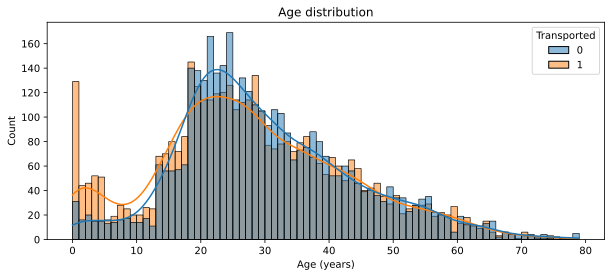

In [253]:
# Histograma de frecuencias "AGE"
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

De 0 a 18 años tenían más probabilidades de ser transportados que no.

De 18 a 25 años tenían menos probabilidades de ser transportados que no.

Desde 25 años tenían la misma probabilidad de ser transportados que los que no.

A partir de este gráfico podemos inferir que sería adecuado crear una nueva característica que indique si el pasajero es niño, adolescente o adulto.

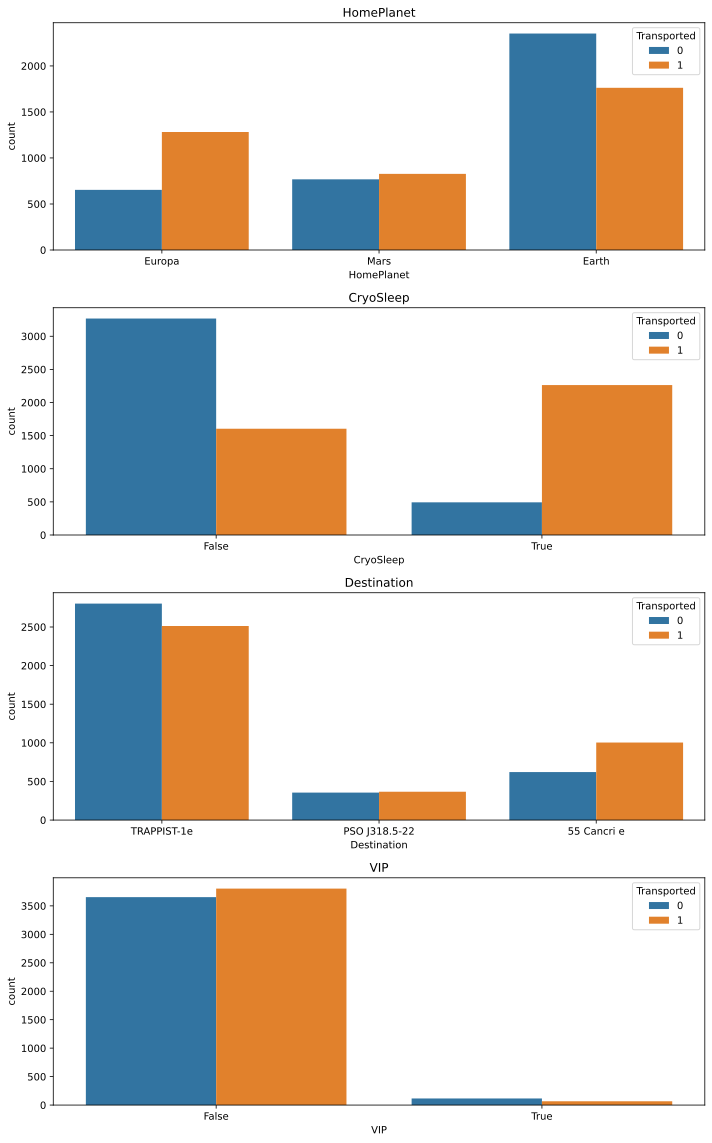

In [254]:
# Variables categóricas
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Gráfico
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

- VIP no parece ser una característica útil, ya que se observa practicamente la misma distribución para transportados y no transportados en ambas categorias VIP.

- HomePlanet y Destination podrían estar relacionadas con nuestra variable objetivo.

- CryoSleep parece ser una característica muy útil para nuestro objetivo.

# **Curación**

In [255]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [256]:
# #Columnas relevantes
rel_cols = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported']

In [257]:
# % de valores faltantes
vf=pd.DataFrame(train[rel_cols].isna().sum(), columns=['Cantidad_faltante'])
vf['Porcentaje de faltantes']=np.round(100*vf['Cantidad_faltante']/len(train),2)
vf

,Cantidad_faltante,Porcentaje de faltantes
PassengerId,0,0.00
HomePlanet,179,2.29
CryoSleep,196,2.51
Cabin,184,2.35
Destination,160,2.05
Age,162,2.07
VIP,184,2.35
RoomService,154,1.97
FoodCourt,155,1.98
ShoppingMall,188,2.40


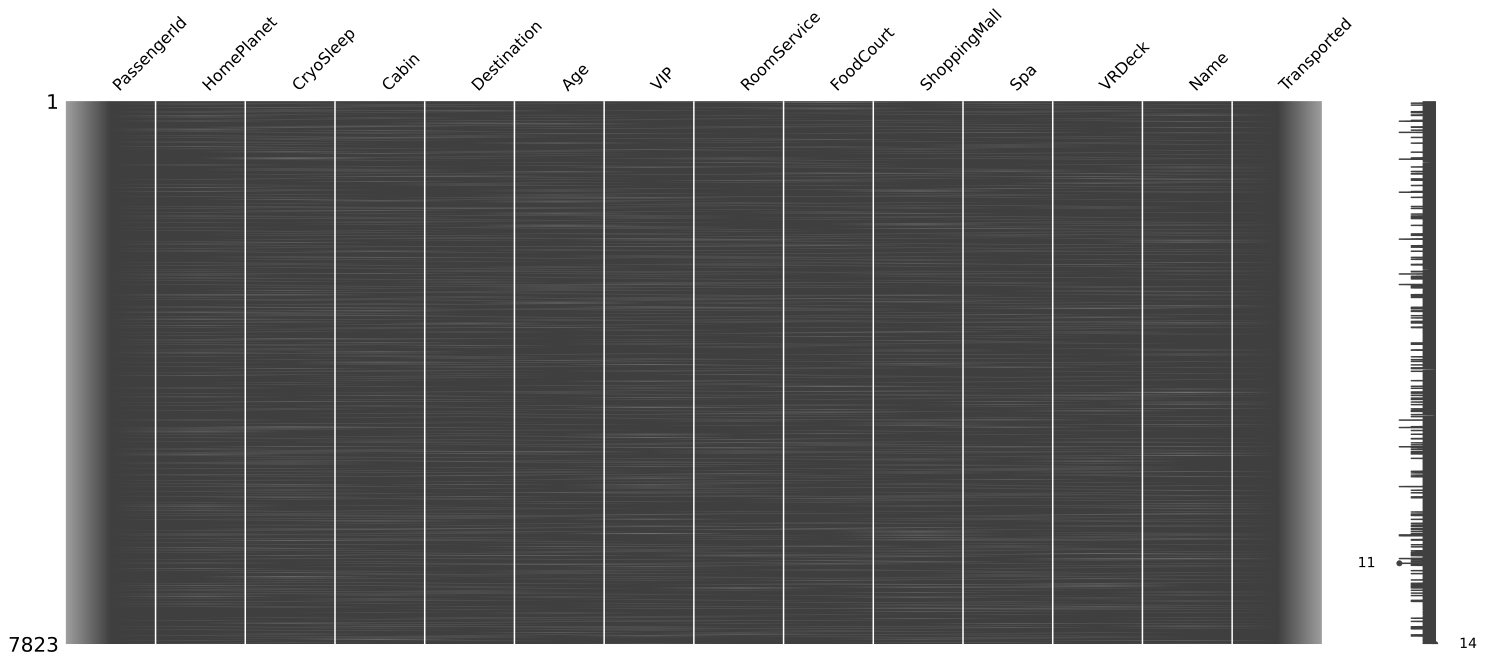

In [258]:
#Vista de valores nulos
msno.matrix(train);

In [259]:
# Imputamos los valores Nan con el valor medio de cada feature
imputer = SimpleImputer (missing_values = np.nan, strategy = 'most_frequent')
train = pd.DataFrame ( imputer.fit_transform(train), columns = train.columns, index = train.index)
train = train.reset_index(drop=True)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1


In [260]:
# Indicamos que la columna Passengerld sea el índice
train = train.set_index('PassengerId')
train.head(2)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
669,Mars,True,F/126/S,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1


# **Transformación**

### Nuevas Features

In [261]:
# División de la variable Cabin
train[['Piso','Número','Lado']] = train.Cabin.str.split(pat = '/', expand = True)
train = train.drop(columns = 'Cabin')
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Piso,Número,Lado
PassengerId,,,,,,,,,,,,,,,
3430,Europa,False,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0,C,123,P
669,Mars,True,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1,F,126,S


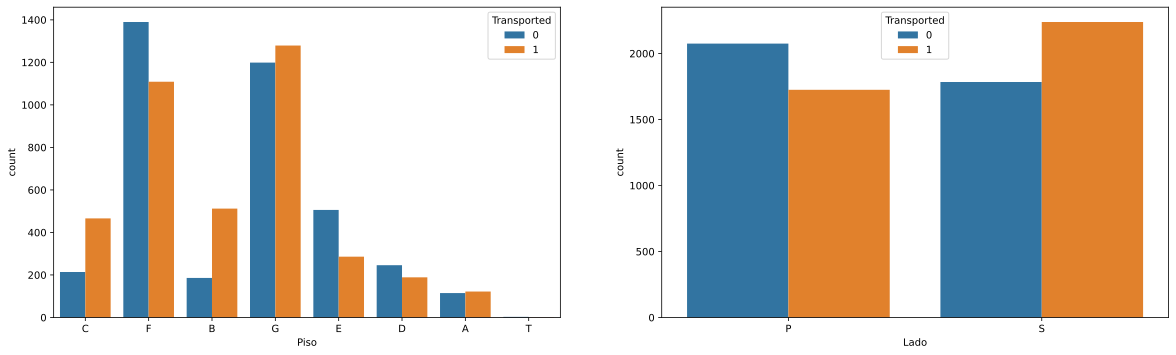

In [262]:
# Graficamos para observar la modificación
features = ['Piso', 'Lado']
plt.figure(figsize = (20, 40))
for i in enumerate(features):
    plt.subplot(6, 2,i[0]+1)
    sns.countplot(x=i[1], data = train, hue='Transported')

* Podemos observar que el pasajero tiene mas probabilidad de ser transportado si esta del lado "S" (estribor) que si esta del lado "P" (Vabor). 

### One Hot encoding
Tendremos que transformar los datos para que sean numéricos (int64 o float64) para que podamos entrenar modelos de aprendizaje automático, ya que en general no funcionan con texto.

In [263]:
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Piso,Número,Lado
PassengerId,,,,,,,,,,,,,,,
3430,Europa,False,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0,C,123,P
669,Mars,True,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1,F,126,S


In [264]:
train = train.drop(columns = 'Name')

train.Transported = train.Transported.astype('int')
train.VIP = train.VIP.astype('int')
train.CryoSleep = train.CryoSleep.astype('int')
train.Age = train.Age.astype('int')
train.RoomService = train.RoomService.astype('int')
train.FoodCourt = train.FoodCourt.astype('int')
train.ShoppingMall = train.ShoppingMall.astype('int')
train.VRDeck = train.VRDeck.astype('int')
train.Spa = train.Spa.astype('int')
train.Número = train.Número.astype('int')
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Piso,Número,Lado
PassengerId,,,,,,,,,,,,,,
3430,Europa,0,TRAPPIST-1e,57,0,0,3859,13,195,3874,0,C,123,P
669,Mars,1,TRAPPIST-1e,18,0,0,0,0,0,0,1,F,126,S


In [265]:
train_df = pd.get_dummies(train, drop_first = True)
train_df.head(2)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Número,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Piso_B,Piso_C,Piso_D,Piso_E,Piso_F,Piso_G,Piso_T,Lado_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
3430,0,57,0,0,3859,13,195,3874,0,123,...,0,1,0,1,0,0,0,0,0,0
669,1,18,0,0,0,0,0,0,1,126,...,0,1,0,0,0,0,1,0,0,1


In [266]:
#Separamos la columna de etiquetas "y"
X = train_df.drop(columns='Transported')
y = train_df.Transported

In [267]:
#División entrenamiento - testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

In [268]:
# power= PowerTransformer(method='yeo-johnson')
# X_train=power.fit_transform(X_train)
# X_test=power.fit_transform(X_test)

StandarScaler

In [269]:
normalizer= preprocessing.StandardScaler()
X_train=normalizer.fit_transform(X_train)
X_test=normalizer.fit_transform(X_test)

# **Planteo de modelos**

Tienen que elegir los 2 mejores modelos así que prueben con varios.

### RandomForestClassifier

In [270]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 
rfc= RandomForestClassifier(random_state=0)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 3, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
print('Mejores parametros:',gridF.best_params_)
print('Mejor Score:',gridF.best_score_)

KeyboardInterrupt: ignored

In [ ]:
rfc= RandomForestClassifier(random_state=0,max_depth=25,min_samples_leaf=1,min_samples_split=10,n_estimators=500)
rfc.fit(X_train,y_train)

train_predictions = rfc.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print('Accuracy train RandomForestClassifier: %.2f%%' % (accuracy * 100.0))

y_pred=rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy test RandomForestClassifier: %.2f%%' % (accuracy *100.0))

plot_confusion_matrix(rfc,X_test,y_test,cmap='cool')
plt.show()
print(' ')
print('        || Reporte de Clasificacion RandomForestClassifier ||')
print(' ')
print(metrics.classification_report(y_test,y_pred))

# **Generar la salida para entregar**

In [184]:
test_df = pd.read_csv('https://raw.githubusercontent.com/CHRISTIANDAGATTI/A.Supervisado---Grupo9/main/test.csv')

In [185]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,Mars,False,F/1212/S,TRAPPIST-1e,54.0,False,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,Earth,True,G/947/S,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,Earth,True,G/1148/P,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,Earth,False,F/293/S,TRAPPIST-1e,18.0,False,765.0,0.0,13.0,0.0,0.0,Herina Oconley


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

Generamos la salida

In [186]:
test_id = PassengerId
test_pred = clf.predict(test_df)


NameError: ignored

In [ ]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)